# Set up workspaec

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sns
from scipy import stats
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/utils/')

In [3]:
CONSTANT_sigma=5.670374419e-8 #Stefan-Boltzmann constant W / (m2 x K4)

In [4]:
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs

# Load Data

In [5]:
ensemble='offline'#'coupled'

In [6]:
if ensemble=='coupled':
    key_ref='COUP0000_PI_SOM'
    base_path_ref='/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/'+key_ref+'/lnd/proc/tseries/'
else:
    key_ref='OFFL0000_PI_v02'
    base_path_ref='/glade/campaign/cgd/tss/czarakas/CoupledPPE/offline_simulations/'+key_ref+'/lnd/proc/tseries/'
    
fsds_ref=xr.open_dataset(base_path_ref+
                   key_ref+'.clm2.h0.timeseries.FSDS.nc')

flds_ref=xr.open_dataset(base_path_ref+
                   key_ref+'.clm2.h0.timeseries.FLDS.nc')

flus_ref=xr.open_dataset(base_path_ref+
                   key_ref+'.clm2.h0.timeseries.FIRE.nc')

fsa_ref=xr.open_dataset(base_path_ref+
                   key_ref+'.clm2.h0.timeseries.FSA.nc')

ts_ref=xr.open_dataset(base_path_ref+
                   key_ref+'.clm2.h0.timeseries.TSKIN.nc')

lh_ref=xr.open_dataset(base_path_ref+
                   key_ref+'.clm2.h0.timeseries.EFLX_LH_TOT.nc')

sh_ref=xr.open_dataset(base_path_ref+
                   key_ref+'.clm2.h0.timeseries.FSH.nc')

In [7]:
from load_gridcell_areas import *

In [488]:
def get_data(key):
    if ensemble=='coupled':
        base_path='/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/'+key+'/lnd/proc/tseries/'
    else:
        base_path='/glade/campaign/cgd/tss/czarakas/CoupledPPE/offline_simulations/'+key+'/lnd/proc/tseries/'
    fsds=xr.open_dataset(base_path+
                       key+'.clm2.h0.timeseries.FSDS.nc')
    flds=xr.open_dataset(base_path+
                       key+'.clm2.h0.timeseries.FLDS.nc')


    flus=xr.open_dataset(base_path+
                       key+'.clm2.h0.timeseries.FIRE.nc')

    fsa=xr.open_dataset(base_path+
                       key+'.clm2.h0.timeseries.FSA.nc')

    ts=xr.open_dataset(base_path+
                       key+'.clm2.h0.timeseries.TSKIN.nc')

    lh=xr.open_dataset(base_path+
                       key+'.clm2.h0.timeseries.EFLX_LH_TOT.nc')

    sh=xr.open_dataset(base_path+
                       key+'.clm2.h0.timeseries.FSH.nc')
    return [fsds, flds, flus, fsa, ts, lh, sh]

# Luyssaert analysis

In [489]:
fsds_init=fsds_ref.FSDS[60*12:,:,:]
ts_init=ts_ref.TSKIN[60*12:,:,:]

In [490]:
def calculate_emissivity(ts, flus):
    emmissivity=CONSTANT_sigma*(ts**4)/flus
    emmissivity=emmissivity.where(emmissivity<1,1).where(~np.isnan(emmissivity))
    return emissivity

def calculate_albedo(fsa, fsds):
    return (1-(fsa/fsds))

In [514]:
def Luyssaert_analysis(key):
    
    ######### Get data
    [fsds, flds, flus, fsa, ts, lh, sh]=get_data(key)
    
    ######### calculate new variables
    emissivity=calculate_emissivity(ts.TSKIN[60*12:,:,:].mean(dim='time'),
                                    flus.FIRE.mean(dim='time'))

    emissivity_ref=calculate_emissivity(ts_init.mean(dim='time'),
                                        flus_ref.FIRE.mean(dim='time'))

    albedo=calculate_albedo(fsa.FSA[60*12:,:,:].mean(dim='time'),
                            fsds.FSDS[60*12:,:,:].mean(dim='time'))

    albedo_ref=calculate_albedo(fsa_ref.FSA[60*12:,:,:].mean(dim='time'),
                            fsds_ref.FSDS[60*12:,:,:].mean(dim='time'))
    
    ##### Calculate deltas

    delta_albedo=albedo-albedo_ref
    delta_emissivity=emissivity-emissivity_ref
    delta_FSDS=(fsds.FSDS[60*12:,:,:].mean(dim='time')-
          fsds_ref.FSDS[60*12:,:,:].mean(dim='time'))
    delta_FLDS=(flds.FLDS[60*12:,:,:].mean(dim='time')-
          flds_ref.FLDS[60*12:,:,:].mean(dim='time'))
    delta_FLUS=(flus.FIRE[60*12:,:,:].mean(dim='time')-
          flus_ref.FIRE[60*12:,:,:].mean(dim='time'))
    delta_FSA=(fsa.FSA[60*12:,:,:].mean(dim='time')-
          fsa_ref.FSA[60*12:,:,:].mean(dim='time'))
    delta_Ts=(ts.TSKIN[60*12:,:,:].mean(dim='time')-
          ts_ref.TSKIN[60*12:,:,:].mean(dim='time'))
    delta_LH=(lh.EFLX_LH_TOT[60*12:,:,:].mean(dim='time')-
          lh_ref.EFLX_LH_TOT[60*12:,:,:].mean(dim='time'))
    delta_SH=(sh.FSH[60*12:,:,:].mean(dim='time')-
          sh_ref.FSH[60*12:,:,:].mean(dim='time'))

    ##### Calculate sensitivities
    factor=(1/(4*CONSTANT_sigma*emissivity*(ts_init.mean(dim='time')**3)))
    dT_d_albedo=-fsds_init.mean(dim='time')*factor
    dT_d_FSDS=((1-albedo_init)*factor)
    dT_d_FLDS=factor
    dT_d_TurbFlux=-factor
    dT_d_emissivity=-CONSTANT_sigma*(ts_init.mean(dim='time')**4)*factor

    ### Calculate incremental temperature changes
    dT_from_albedo=(dT_d_albedo*delta_albedo)#.mean(dim='time')
    dT_from_FSDS=(dT_d_FSDS*delta_FSDS)#.mean(dim='time')
    dT_from_FLDS=(dT_d_FLDS*delta_FLDS)#.mean(dim='time')
    dT_from_LH=(dT_d_TurbFlux*delta_LH)#.mean(dim='time')
    dT_from_SH=(dT_d_TurbFlux*delta_SH)#.mean(dim='time')
    dT_from_LHandSH=(dT_from_LH+dT_from_SH)
    dT_from_emissivity=(dT_d_emissivity*delta_emissivity)

    dT_est=(dT_from_FLDS+dT_from_albedo+dT_from_FSDS+dT_from_LHandSH)
    error=delta_Ts-dT_est

    ### Calculate global means
    dT_from_FLDS_global=(dT_from_FLDS*landweights).mean(dim=['lat','lon']).values
    dT_from_FSDS_global=(dT_from_FSDS*landweights).mean(dim=['lat','lon']).values
    dT_from_albedo_global=(dT_from_albedo*landweights).mean(dim=['lat','lon']).values
    dT_from_SH_global=(dT_from_SH*landweights).mean(dim=['lat','lon']).values
    dT_from_LH_global=(dT_from_LH*landweights).mean(dim=['lat','lon']).values
    dT_from_LHandSH_global=(dT_from_LHandSH*landweights).mean(dim=['lat','lon']).values
    dT_from_emissivity_global=(dT_from_emissivity*landweights).mean(dim=['lat','lon']).values
    error_global=(error*landweights).mean(dim=['lat','lon']).values
    total_global=(delta_Ts*landweights).mean(dim=['lat','lon']).values

    return [[delta_Ts, dT_from_FLDS, dT_from_FSDS, dT_from_albedo,
              dT_from_LHandSH, dT_from_LH, dT_from_SH, dT_from_emissivity, error],
            [total_global, dT_from_FLDS_global, dT_from_FSDS_global, dT_from_albedo_global,
              dT_from_LHandSH_global, dT_from_emissivity_global, error_global]]

In [518]:
total_globals=[]
dT_from_FLDS_globals=[]
dT_from_FSDS_globals=[]
dT_from_albedo_globals=[]
dT_from_LHandSH_globals=[]
dT_from_emissivity_globals=[]
error_globals=[]
keys_list=[]

In [519]:
for key in ['OFFL0001_PI_v02','OFFL0002_PI_v02','OFFL0003_PI_v02','OFFL0004_PI_v02',
            'OFFL0005_PI_v02','OFFL0006_PI_v02','OFFL0007_PI_v02','OFFL0008_PI_v02',
            'OFFL0009_PI_v02','OFFL0010_PI_v02','OFFL0011_PI_v02','OFFL0012_PI_v02',
            'OFFL0013_PI_v02','OFFL0014_PI_v02','OFFL0015_PI_v02','OFFL0016_PI_v02',
            'OFFL0017_PI_v02','OFFL0018_PI_v02','OFFL0019_PI_v02','OFFL0020_PI_v02',
            'OFFL0021_PI_v02','OFFL0022_PI_v02','OFFL0023_PI_v02','OFFL0024_PI_v02',
            'OFFL0025_PI_v02','OFFL0026_PI_v02','OFFL0027_PI_v02','OFFL0028_PI_v02',
            'OFFL0029_PI_v02','OFFL0030_PI_v02','OFFL0031_PI_v02','OFFL0032_PI_v02',
            'OFFL0033_PI_v02','OFFL0034_PI_v02','OFFL0035_PI_v02','OFFL0036_PI_v02']:
    print(key)
    [[delta_Ts, dT_from_FLDS, dT_from_FSDS, dT_from_albedo,
                  dT_from_LHandSH, dT_from_LH, dT_from_SH, dT_from_emissivity, error],
     [total_global, dT_from_FLDS_global, dT_from_FSDS_global, dT_from_albedo_global,
                  dT_from_LHandSH_global, dT_from_emissivity_global, error_global]] = Luyssaert_analysis(key=key)

    total_globals.append(total_global)
    dT_from_FLDS_globals.append(dT_from_FLDS_global)
    dT_from_FSDS_globals.append(dT_from_FSDS_global)
    dT_from_albedo_globals.append(dT_from_albedo_global)
    dT_from_LHandSH_globals.append(dT_from_LHandSH_global)
    dT_from_emissivity_globals.append(dT_from_emissivity_global)
    error_globals.append(error_global)
    keys_list.append(key)

OFFL0001_PI_v02
OFFL0002_PI_v02
OFFL0003_PI_v02
OFFL0004_PI_v02
OFFL0005_PI_v02
OFFL0006_PI_v02
OFFL0007_PI_v02
OFFL0008_PI_v02
OFFL0009_PI_v02
OFFL0010_PI_v02
OFFL0011_PI_v02
OFFL0012_PI_v02
OFFL0013_PI_v02
OFFL0014_PI_v02
OFFL0015_PI_v02
OFFL0016_PI_v02
OFFL0017_PI_v02
OFFL0018_PI_v02
OFFL0019_PI_v02
OFFL0020_PI_v02
OFFL0021_PI_v02
OFFL0022_PI_v02
OFFL0023_PI_v02
OFFL0024_PI_v02
OFFL0025_PI_v02
OFFL0026_PI_v02
OFFL0027_PI_v02
OFFL0028_PI_v02
OFFL0029_PI_v02
OFFL0030_PI_v02
OFFL0031_PI_v02
OFFL0032_PI_v02
OFFL0033_PI_v02
OFFL0034_PI_v02
OFFL0035_PI_v02
OFFL0036_PI_v02


Text(0, 0.5, '$\\Delta$T$_{albedo}$')

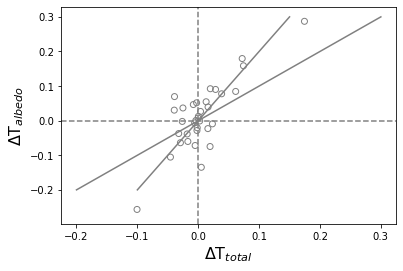

In [533]:
y=dT_from_albedo_globals_coupled[1:]
x=dT_from_albedo_globals[2:]
plt.scatter(x, y,facecolors='none',edgecolors='gray')
for i,key in enumerate(keys_list):
    if np.abs(total_globals[i])>100:#0.5:
        plt.annotate(key,(x[i],y[i]))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axvline(x=0,linestyle='--',color='gray')
plt.plot([-0.2,0.3],[-0.2,0.3],'-',color='gray')
plt.plot([-0.1,0.15],[-0.2,0.3],'-',color='gray')
plt.xlabel('$\Delta$T$_{total}$', fontsize=16)
plt.ylabel('$\Delta$T$_{albedo}$', fontsize=16)

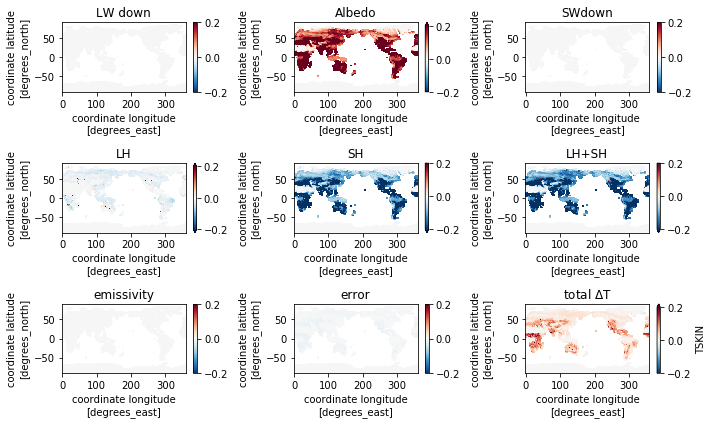

In [516]:
vmin=-0.2
vmax=0.2
plt.figure(figsize=(10,6))
plt.subplot(3,3,1)
(dT_from_FLDS).plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('LW down')

plt.subplot(3,3,2)
dT_from_albedo.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('Albedo')

plt.subplot(3,3,3)
dT_from_FSDS.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('SWdown')

plt.subplot(3,3,4)
dT_from_LH.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('LH')

plt.subplot(3,3,5)
dT_from_SH.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('SH')

plt.subplot(3,3,6)
dT_from_LHandSH.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('LH+SH')

plt.subplot(3,3,7)
dT_from_emissivity.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('emissivity')

plt.subplot(3,3,8)
error.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('error')

plt.subplot(3,3,9)
delta_Ts.plot(vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.title('total $\Delta$T')

plt.tight_layout()

### Print changes

In [492]:
total_globals_coupled=total_globals
dT_from_FLDS_globals_coupled=dT_from_FLDS_globals
dT_from_FSDS_globals_coupled=dT_from_FSDS_globals
dT_from_albedo_globals_coupled=dT_from_albedo_globals
dT_from_LHandSH_globals_coupled=dT_from_LHandSH_globals
dT_from_emissivity_globals_coupled=dT_from_emissivity_globals
error_globals_coupled=error_globals
keys_list_coupled=keys_list

In [480]:
names=['Total','FLDS','FSDS','albedo','LH+SH','emissivity','error','keys']
for j,this_list in enumerate([total_globals, dT_from_FLDS_globals, dT_from_FSDS_globals, dT_from_albedo_globals,
 dT_from_LHandSH_globals, dT_from_emissivity_globals, error_globals, keys_list]):
    print(names[j])
    for i,key in enumerate(keys_list):
        print(this_list[i])
    print('------')


Total
0.4195857
0.11445504
-0.090918384
0.24052507
0.20108669
-0.42411596
1.0136648
-1.2108659
0.49399439
-0.006671588
-0.02008606
0.38585344
-0.33622897
0.8227879
-0.3759575
0.076283984
-0.17512731
-0.567549
0.112113275
0.4302532
-0.1518599
-0.3928763
0.61758196
-0.21848522
0.76143634
-0.1655845
0.5172798
-0.03165416
0.14066738
-0.06741574
0.53550386
0.6316489
-0.96332204
0.024939325
-0.032770876
------
FLDS
0.38418338
0.030870574
-0.051491197
0.2882571
0.17322704
-0.31938028
0.6813118
-0.8310628
0.39371443
-0.057306692
0.5310129
0.15474881
-0.12875587
0.32578138
-0.24151583
0.12459443
-0.20839301
-0.44267702
0.11711528
0.2631999
-0.087759
-0.22483863
0.26943246
-0.10949873
0.4135547
-0.057077527
0.5096345
0.03794007
-0.02008141
-0.002891468
0.3203765
0.35639247
-0.68810546
-0.050536737
-0.0028332167
------
FSDS
-0.033697445
0.024186026
-0.002241063
-0.036476407
0.02319441
-0.04533738
0.13402297
-0.21920048
0.049185917
-0.049613707
-0.019682894
0.13501632
-0.16935474
0.28370017
-0.066

# Energy budget

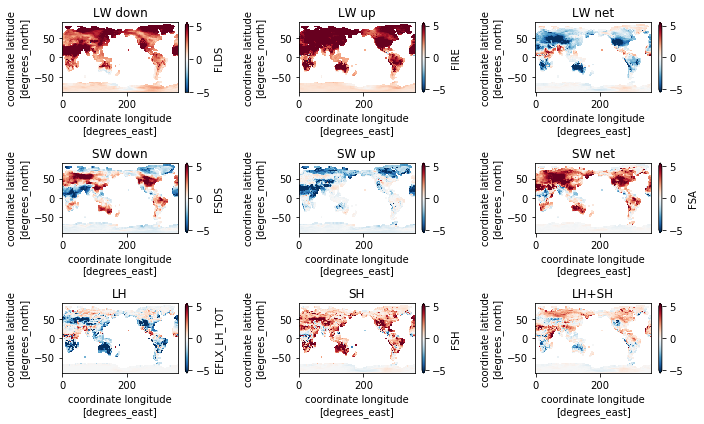

In [325]:
plt.figure(figsize=(10,6))
plt.subplot(3,3,1)
(delta_FLDS).plot(vmin=-5, vmax=5, cmap=plt.cm.RdBu_r)
plt.title('LW down')
plt.subplot(3,3,2)
delta_FLUS.plot(vmin=-5, vmax=5, cmap=plt.cm.RdBu_r)
plt.title('LW up')
plt.subplot(3,3,3)
(delta_FLDS-delta_FLUS).plot(vmin=-5, vmax=5, cmap=plt.cm.RdBu_r)
plt.title('LW net')
plt.subplot(3,3,4)
delta_FSDS.plot(vmin=-5, vmax=5, cmap=plt.cm.RdBu_r)
plt.title('SW down')
plt.subplot(3,3,5)
(delta_FSDS-delta_FSA).plot(vmin=-5, vmax=5, cmap=plt.cm.RdBu_r)
plt.title('SW up')
plt.subplot(3,3,6)
(delta_FSA).plot(vmin=-5, vmax=5, cmap=plt.cm.RdBu_r)
plt.title('SW net')
plt.subplot(3,3,7)
(delta_LH).plot(vmin=-5, vmax=5, cmap=plt.cm.RdBu_r)
plt.title('LH')
plt.subplot(3,3,8)
(delta_SH).plot(vmin=-5, vmax=5, cmap=plt.cm.RdBu_r)
plt.title('SH')
plt.subplot(3,3,9)
(delta_SH+delta_LH).plot(vmin=-5, vmax=5, cmap=plt.cm.RdBu_r)
plt.title('LH+SH')
plt.tight_layout()

In [28]:
ds=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/CTL2010/hist/'+
                   'PPEn08_CTL2010_OAAT0295.clm2.h0.2005-02-01-00000.nc')

In [30]:
ds#.time

<xarray.Dataset>
Dimensions:                            (cft: 2, column: 2599, gridcell: 400, hist_interval: 2, landunit: 1148, lat: 96, levdcmp: 25, levgrnd: 25, levlak: 10, levsoi: 20, lon: 144, ltype: 9, nvegwcs: 4, pft: 4387, time: 120)
Coordinates:
  * levgrnd                            (levgrnd) float32 0.01 0.04 ... 41.998436
  * levsoi                             (levsoi) float32 0.01 0.04 ... 6.94 8.03
  * levlak                             (levlak) float32 0.05 0.6 ... 44.775
  * levdcmp                            (levdcmp) float32 0.01 0.04 ... 41.998436
  * time                               (time) object 2005-02-01 00:00:00 ... 2015-01-01 00:00:00
  * lon                                (lon) float32 0.0 2.5 5.0 ... 355.0 357.5
  * lat                                (lat) float32 -90.0 -88.10526 ... 90.0
Dimensions without coordinates: cft, column, gridcell, hist_interval, landunit, ltype, nvegwcs, pft
Data variables:
    mcdate                             (time) int32 ...


In [ ]:
ALT, AR, FGR, FGR12
EFLX_LH_TOT, FSH
FSA, FSDS, FIRA
TSKIN, TSOI_10CM, TV
    FSM                 (time, gridcell) float32 ...
    FSNO                (time, gridcell) float32 ...
    GPP                 (time, gridcell) float32 ...
    H2OSFC              (time, gridcell) float32 ...
    H2OSNO              (time, gridcell) float32 ...
    H2OSOI              (time, levsoi, gridcell) float32 ...
    HR                  (time, gridcell) float32 ...
    NPP                 (time, gridcell) float32 ...
    QDRAI               (time, gridcell) float32 ...
    QDRAI_PERCH         (time, gridcell) float32 ...
    QINTR               (time, gridcell) float32 ...
    QOVER               (time, gridcell) float32 ...
    QRUNOFF             (time, gridcell) float32 ...
    QSOIL               (time, gridcell) float32 ...
    QVEGE               (time, gridcell) float32 ...
    QVEGT               (time, gridcell) float32 ...
    SNOWDP              (time, gridcell) float32 ...
    SNOWICE             (time, gridcell) float32 ...
    SNOWLIQ             (time, gridcell) float32 ...
    SOILWATER_10CM      (time, gridcell) float32 ...
    TG                  (time, gridcell) float32 ...
    TLAI                (time, gridcell) float32 ...
                   (time, gridcell) float32 ...
               (time, gridcell) float32 ...
                      (time, gridcell) float32 ...
    TWS                 (time, gridcell) float32 ...
    VEGWPLN             (time, nvegwcs, gridcell) float32 ...
    VEGWPPD             (time, nvegwcs, gridcell) float32 ...
    VPD_CAN             (time, gridcell) float32 ...

In [13]:
ds#.time

<xarray.Dataset>
Dimensions:             (column: 2599, gridcell: 400, hist_interval: 2, landunit: 1148, lat: 96, levdcmp: 25, levgrnd: 25, levlak: 10, levsoi: 20, lon: 144, nvegwcs: 4, pft: 4387, time: 3651)
Coordinates:
  * levgrnd             (levgrnd) float32 0.01 0.04 0.09 ... 28.870724 41.998436
  * levsoi              (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.95 6.94 8.03
  * levlak              (levlak) float32 0.05 0.6 2.1 4.6 ... 25.6 34.325 44.775
  * levdcmp             (levdcmp) float32 0.01 0.04 0.09 ... 28.870724 41.998436
  * time                (time) object 2005-01-01 00:00:00 ... 2015-01-01 00:00:00
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                 (lat) float32 -90.0 -88.10526 ... 88.10526 90.0
Dimensions without coordinates: column, gridcell, hist_interval, landunit, nvegwcs, pft
Data variables:
    mcdate              (time) int32 ...
    mcsec               (time) int32 ...
    mdcur               (time) int32 ..

# Check feedback analysis scripts

In [47]:
vars_list=['TS','TREFHT','FLDS','FLNS','FLNTC','FLNT',
          'FLUTC','FLUT','FSDS','FSNS','FSNTC','FSNT','PRECC','PRECL',
          #'PRECSC','PRECSL','P0','PHIST', 'T','Q',
          'LHFLX','SHFLX','PS']
sim='COUP0000_PI_SOM'
for var in vars_list:
    ds = xr.open_dataset('/glade/work/czarakas/coupled_PPE/data/postprocessed_model_output/'+sim+'/'+
                     sim+'.cam.h0.timeseries.'+var+'.nc')
    print(np.size(ds.time))
    print(ds.time.values[0])
    print('-----')

1680
0049-01-16 12:00:00
-----
1680
0049-01-16 12:00:00
-----
1680
0049-01-16 12:00:00
-----
1680
0049-01-16 12:00:00
-----
1680
0049-01-16 12:00:00
-----
1680
0049-01-16 12:00:00
-----
1680
0049-01-16 12:00:00
-----
1680
0049-01-16 12:00:00
-----
1680
0049-01-16 12:00:00
-----
1680
0049-01-16 12:00:00
-----
1680
0049-01-16 12:00:00
-----
1680
0049-01-16 12:00:00
-----
1680
0049-01-16 12:00:00
-----
1680
0049-01-16 12:00:00
-----
1680
0049-01-16 12:00:00
-----
1680
0049-01-16 12:00:00
-----
1680
0049-01-16 12:00:00
-----


In [50]:
var='gw'
ds = xr.open_dataset('/glade/work/czarakas/coupled_PPE/data/postprocessed_model_output/'+sim+'/'+
                     sim+'.cam.h0.timeseries.'+var+'.nc')

In [51]:
ds

<xarray.Dataset>
Dimensions:  (lat: 96)
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
Data variables:
    gw       (lat) float64 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              COUP0000_PI_SOM
    logname:           czarakas
    host:              cheyenne5
    initial_file:      /glade/p/cesmdata/cseg/inputdata/cesm2_init/b.e20.B185...
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_1.9x2...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1
    history:           Wed Feb  1 12:28:19 2023: ncks -v gw /glade/campaign/c...
    NCO:               netCDF Operators version 5.0.3 (Homepage = http://nco....

In [69]:
ds_full = xr.open_dataset('/glade/work/czarakas/coupled_PPE/data/postprocessed_model_output/COUP0001_PI_SOM_v02/'+
                     'COUP0001_PI_SOM_v02.cam.h0.timeseries.LHFLX.nc')

<xarray.DataArray 'LHFLX' (time: 1680, lat: 96, lon: 144)>
[23224320 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 0049-01-16 12:00:00 ... 0188-12-16 12:00:00
Attributes:
    units:         W/m2
    long_name:     Surface latent heat flux
    cell_methods:  time: mean

In [70]:
ds = xr.open_dataset('/glade/work/czarakas/coupled_PPE/data/postprocessed_model_output_noSpinUp/COUP0001_PI_SOM_v02/'+
                     'COUP0001_PI_SOM_v02.cam.h0.timeseries.LHFLX.nc')

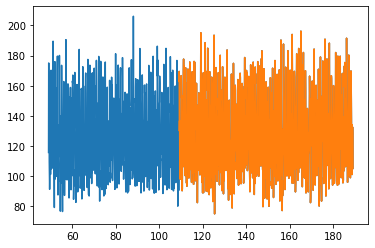

In [79]:

plt.plot(ds_full['time.year']+ds_full['time.month']/12, ds_full.LHFLX[:,50,50])
plt.plot(ds['time.year']+ds['time.month']/12, ds.LHFLX[:,50,50])

In [82]:
np.nanmin(ds_full.LHFLX-ds.LHFLX)

0.0

In [86]:
ds = xr.open_dataset('/glade/work/czarakas/coupled_PPE/data/postprocessed_model_output/COUP0001_PI_SOM_v02/'+
                     'COUP0001_PI_SOM_v02.cam.h0.timeseries.hyam.nc')

In [87]:
ds

<xarray.Dataset>
Dimensions:  (ilev: 33, lat: 96, lev: 32, lon: 144, time: 1)
Coordinates:
  * ilev     (ilev) float64 2.255 5.032 10.16 18.56 ... 947.4 967.5 985.1 1e+03
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
Dimensions without coordinates: lat, lon, time
Data variables:
    P0       float64 ...
    PS       (time, lat, lon) float32 ...
    hyai     (ilev) float64 ...
    hyam     (lev) float64 ...
    hybi     (ilev) float64 ...
    hybm     (lev) float64 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              COUP0001_PI_SOM_v02
    logname:           czarakas
    host:              cheyenne1
    initial_file:      /glade/p/cesmdata/cseg/inputdata/cesm2_init/b.e20.B185...
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_1.9x2...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1
    history:           Wed Feb  1 12:31:43 2023: ncks -v hyam /glade

In [61]:
720/12

60.0